In [13]:
#from supportFunctions import *
import cPickle as pickle
from __future__ import division
import numpy as np
from sklearn import tree
#import seaborn as sn
import pandas as pd 

import scipy.cluster.hierarchy as hcluster
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



In [14]:
class clsf_Performance(object):
    """The performance of a classifier can be evaluated in different manners.

    Attributes:
        y_hat: clf output
        y_test: true values
    """

    def __init__(self, y_hat, y_test):
        
        self.y_hat = y_hat
        self.y_test = y_test

    def print_confusion_matrix(self, is_normalized = True):
        """Plots the confusion matrix."""
        if is_normalized == True : 
            normalized_confusion_matrix = confusion_matrix(self.y_test, self.y_hat)/confusion_matrix(self.y_test, self.y_hat).sum()
            df_confusion_normalized = pd.DataFrame(normalized_confusion_matrix, index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])

            plt.figure(figsize = (9,6))
            sn.set(font_scale=2)
            sn.heatmap(df_confusion_normalized, annot = True, fmt='.4g')
            plt.show()
        else:
            df_confusion = pd.DataFrame(confusion_matrix(self.y_test, self.y_hat), index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])
            plt.figure(figsize = (9,6))
            sn.set(font_scale=2)
            sn.heatmap(df_confusion, annot = True, fmt='.4g')
            plt.show()
    
    
    def Accuracy(self, normalize = True):
        return(accuracy_score(self.y_test, self.y_hat, normalize = normalize))
        
    def Recall(self):
        return(recall_score(self.y_test, self.y_hat))
    
    def Precision(self):
        return(precision_score(self.y_test, self.y_hat))
        
    def print_ROC(self, label = None):
        fpr, tpr, _ = roc_curve(self.y_test, self.y_hat )
        plt.plot(fpr, tpr, label = label )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
  
    def AUC(self):
        fpr, tpr, _ = roc_curve(self.y_test, self.y_hat)
        return(auc(fpr, tpr))
    

In [15]:
def plots_estimates_and_actuals(testingExampleIndices,yHat, testY, data):
    """
    For given yHat(estimated), testY(actual), and test examples,
    it visualizes these in subplots.
    
    yHat and testY should be vectors 
    
    """
    fig = plt.figure(0, (8, 6))
    Y_hat = Reshape_to_yHatMatrix(testingExamples, yHat)
    Y_test = Reshape_to_yHatMatrix(testingExamples, testY)
    for i in range(len(testingExampleIndices)):
        
        fig.add_subplot(1,len(testingExampleIndices),i+1)
        imageDict = data[testingExampleIndices[i]]
        #im = makeGrayScale(imageDict)
        im = imageDict['croppedImage']
        im2 = im.copy()

        #Paint with matches:
        im[Y_test[i]==1] = [90]
        im2[Y_hat[i]==1] = 0
        
        
        
        plt.imshow(im2, interpolation = 'none')
        plt.imshow(im, interpolation = 'none', alpha = 0.3)
    plt.show()

In [16]:
def plot_confusion_matrix(testY, yHat, is_normalized = True):
    if is_normalized == True : 
        normalized_confusion_matrix = confusion_matrix(testY, yHat)/confusion_matrix(testY, yHat).sum()
        df_confusion_normalized = pd.DataFrame(normalized_confusion_matrix, index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])

        plt.figure(figsize = (9,6))
        sn.set(font_scale=2)
        sn.heatmap(df_confusion_normalized, annot = True, fmt='.4g')
        plt.show()
    else:
        df_confusion = pd.DataFrame(confusion_matrix(testY, yHat), index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])
        plt.figure(figsize = (9,6))
        sn.set(font_scale=2)
        sn.heatmap(df_confusion, annot = True, fmt='.4g')
        plt.show()
        

In [17]:
def extractFeatures(imageDict, dist = 5):
    n = imageDict['numPointsInBox']
    y = np.zeros(n)
    
    v1,v2,h1,h2 = imageDict['boxEdges']
    
    img = imageDict['image1bit']
    featuresList = []
    
    fingerSet = imageDict['allFingerPoints']

    c = 0 
    for i in range(h1,h2):
        for j in range(v1,v2):
            x_matrix  = img[i-dist-1:i+dist , j-dist-1: j+dist]
            xVec = x_matrix.ravel()
            featuresList.append(xVec)
            
            if max(np.sum([i , j] == fingerSet, axis = 1 )) == 2:
                y[c] = 1
            
            c = c + 1

    X = np.vstack((featuresList))
    return(X,y)
    

In [18]:
def extractExamplesFromList(imageList, dist = 5):
    allFeaturesList = []
    allTargetList = []

    for i, imageDict in enumerate(imageList):
        features, target = extractFeatures(imageDict, dist = dist)
        allFeaturesList.append(features)
        allTargetList.append(target)

    x = np.vstack((allFeaturesList))
    y = np.hstack((allTargetList))
    
    return x, y

In [19]:
def Reshape_to_yHatMatrix(testingExamples, yHat):
    number_of_images = len(testingExamples)
    
    image_sizes = []
    result = []
    c = 0 
    for i in range(number_of_images):
        dummy_idx = (testingExamples[i]['boxHeight'],testingExamples[i]['boxWidth'])
        image_sizes.append(dummy_idx)
        
        test_im = yHat[c:(c + dummy_idx[0]*dummy_idx[1])] 
        c = c + (dummy_idx[0] * dummy_idx[1])
        
        test_im_matrix = test_im.reshape((dummy_idx[0], dummy_idx[1]))
        result.append(test_im_matrix)
    
    return(result)

In [20]:
def remove_small_clusters(clusters, min_finger_pixel):
    unique = set(clusters)
    for c in unique:
        if sum(clusters == c) < min_finger_pixel:
            clusters = np.delete(clusters, np.where(clusters == c))
    return(clusters)

In [109]:
def Y_hat_list_to_numFingers_list(Y_hat):
    n_foto = len(Y_hat)
    num_finger_list = []
    for i in range(n_foto):
        X_i = np.where(Y_hat[i] == 1)[0]
        X_j = np.where(Y_hat[i] == 1)[1]

        data_cl  = np.column_stack((X_i, X_j))
        
        thresh = 1
        clusters = hcluster.fclusterdata(data_cl, thresh, criterion="distance")
        #removing small clusters (caused by false positives)
        new_clusters = remove_small_clusters(clusters,15)
        num_finger_list.append(len(set(new_clusters)))
        
    return(num_finger_list)

In [21]:
#sn.set_style("white")

# Loading the Data and Extracting Features

In [22]:
pickleFileName = 'fingerDataSet' + '.pickle'
pickleFile = open(pickleFileName, 'rb')
data = pickle.load(pickleFile)
pickleFile.close()

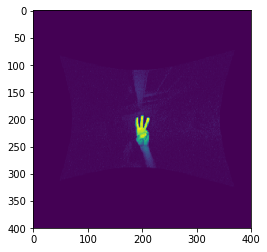

In [23]:
plt.imshow(data[51]['image'])
plt.show()

In [94]:
#Constructing Traning Data Set:
trainingExampleIndices = np.arange(0,45)
trainingExamples = [data[index] for index in trainingExampleIndices]
trainX, trainY = extractExamplesFromList(trainingExamples, dist = 4)

#Constructing Test Data Set:
testingExampleIndices = [46, 47, 48, 49, 50, 51, 52, 53]
testingExamples = [data[index] for index in testingExampleIndices]
testX, testY = extractExamplesFromList(testingExamples, dist = 4)


In [115]:
testing_y_fingernumbers = [data[index]['numFingers'] for index in testingExampleIndices]
print( 'True number of fingers in the test set ' + str(testing_y_fingernumbers) )


True number of fingers in the test set [3, 3, 3, 3, 3, 3, 3, 3]


# Decision Tree 

In [116]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5)
clf = clf.fit(trainX, trainY)
yHat = clf.predict(testX)

### Performance Evaluation 

In [117]:
DT_perf = clsf_Performance(y_hat=yHat, y_test=testY)

print ('Accuracy: '+ str(DT_perf.Accuracy()))
print ('Recall: '+ str(DT_perf.Recall()))
print ('Precision: '+ str(DT_perf.Precision()))
print ('AUC: '+ str(DT_perf.AUC()))




Accuracy: 0.961051654205
Recall: 0.631891891892
Precision: 0.909727626459
AUC: 0.812829844297


In [118]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, yHat)

print 'Predicted number of fingers in the test set :' 
print Y_hat_list_to_numFingers_list(Y_hat)
print 'True number of fingers in the test set : '
print testing_y_fingernumbers



Predicted number of fingers in the test set :
[3, 3, 3, 3, 3, 3, 3, 3]
True number of fingers in the test set : 
[3, 3, 3, 3, 3, 3, 3, 3]


### Plotting Fitted images 

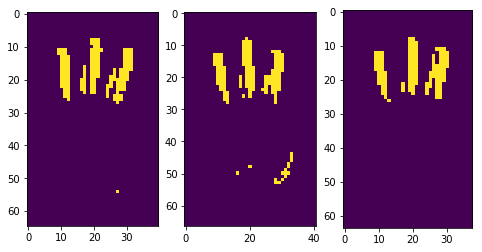

In [119]:
fig = plt.figure(0, (8, 4))
plt.subplot(1,3,1)
plt.imshow(Y_hat[0])
plt.subplot(1,3,2)
plt.imshow(Y_hat[1])
plt.subplot(1,3,3)
plt.imshow(Y_hat[2])
plt.show()

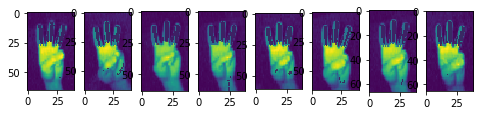

In [120]:
plots_estimates_and_actuals(testingExampleIndices,yHat, testY, data) # Duzelmesi Lazim 

# Logistic Regression

In [121]:
from sklearn.linear_model import LogisticRegression

In [122]:
classifier = LogisticRegression(random_state=0)
classifier.fit (trainX, trainY)
y_hat_logi = classifier.predict(testX)

## Performance Evaluation

In [123]:
Logi_perf = clsf_Performance(y_hat= y_hat_logi, y_test=testY)

print ('Accuracy: '+ str(Logi_perf.Accuracy()))
print ('Recall: '+ str(Logi_perf.Recall()))
print ('Precision: '+ str(Logi_perf.Precision()))
print ('AUC: '+ str(Logi_perf.AUC()))




Accuracy: 0.962224502761
Recall: 0.622702702703
Precision: 0.938875305623
AUC: 0.809336630457


In [124]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_logi)

print 'Predicted number of fingers in the test set :' 
print Y_hat_list_to_numFingers_list(Y_hat)
print 'True number of fingers in the test set : '
print testing_y_fingernumbers




Predicted number of fingers in the test set :
[3, 3, 3, 3, 3, 3, 3, 3]
True number of fingers in the test set : 
[3, 3, 3, 3, 3, 3, 3, 3]


## Plotting the fitted Images

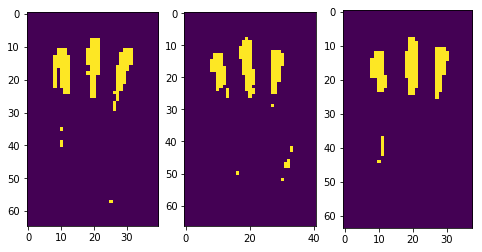

In [125]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_logi)

fig = plt.figure(0, (8, 4))
plt.subplot(1,3,1)
plt.imshow(Y_hat[0])
plt.subplot(1,3,2)
plt.imshow(Y_hat[1])
plt.subplot(1,3,3)
plt.imshow(Y_hat[2])
plt.show()

# Random Forest 

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [128]:
classifier_RF = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state= 0)
classifier_RF.fit(trainX, trainY)
y_hat_RF = classifier_RF.predict(testX)

## Performance Evaluation 

In [129]:
RF_perf = clsf_Performance(y_hat= y_hat_RF, y_test=testY)

print ('Accuracy: '+ str(RF_perf.Accuracy()))
print ('Recall: '+ str(RF_perf.Recall()))
print ('Precision: '+ str(RF_perf.Precision()))
print ('AUC: '+ str(RF_perf.AUC()))



Accuracy: 0.981478766554
Recall: 0.856756756757
Precision: 0.932901706886
AUC: 0.92531600262


In [130]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_RF)

print 'Predicted number of fingers in the test set :' 
print Y_hat_list_to_numFingers_list(Y_hat)
print 'True number of fingers in the test set : '
print testing_y_fingernumbers



Predicted number of fingers in the test set :
[3, 3, 3, 3, 3, 3, 3, 3]
True number of fingers in the test set : 
[3, 3, 3, 3, 3, 3, 3, 3]


## Plotting the Fitted Images

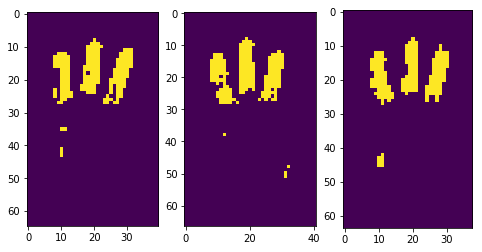

In [131]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_RF)

fig = plt.figure(0, (8, 4))
plt.subplot(1,3,1)
plt.imshow(Y_hat[0])
plt.subplot(1,3,2)
plt.imshow(Y_hat[1])
plt.subplot(1,3,3)
plt.imshow(Y_hat[2])
plt.show()

# MLP

In [132]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(54, 27, 3))
mlp.fit(trainX , trainY)
y_hat_ANN = mlp.predict(testX)

## Performance Evaluation

In [133]:
MLP_perf = clsf_Performance(y_hat= y_hat_ANN, y_test=testY)

print ('Accuracy: '+ str(MLP_perf.Accuracy()))
print ('Recall: '+ str(MLP_perf.Recall()))
print ('Precision: '+ str(MLP_perf.Precision()))
print ('AUC: '+ str(MLP_perf.AUC()))



Accuracy: 0.982456140351
Recall: 0.885405405405
Precision: 0.917647058824
AUC: 0.93875384975


In [134]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_ANN)

print 'Predicted number of fingers in the test set :' 
print Y_hat_list_to_numFingers_list(Y_hat)
print 'True number of fingers in the test set : '
print testing_y_fingernumbers




Predicted number of fingers in the test set :
[3, 3, 3, 3, 3, 3, 3, 3]
True number of fingers in the test set : 
[3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:
X_i = np.where(Y_hat[1] == 1)[0]
X_j = np.where(Y_hat[1] == 1)[1]

data_cl  = np.column_stack((X_i, X_j))
data_cl.shape

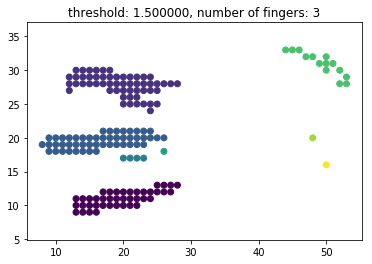

In [72]:
# clustering
thresh = 1.5
clusters = hcluster.fclusterdata(data_cl, thresh, criterion="distance")
#removing small clusters (caused by false positives)
new_clusters = remove_small_clusters(clusters,15)

# plotting
plt.scatter(*np.transpose(data_cl), c=clusters)
plt.axis("equal")
title = "threshold: %f, number of fingers: %d" % (thresh, len(set(new_clusters)))
plt.title(title)
plt.show()

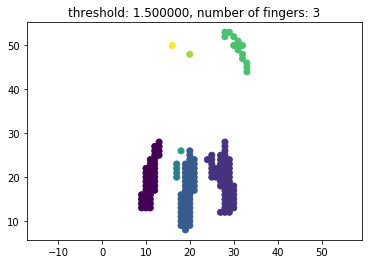

In [73]:
plt.scatter(np.array(data_cl)[:,1], np.array(data_cl)[:,0] , c=clusters)
plt.axis("equal")
title = "threshold: %f, number of fingers: %d" % (thresh, len(set(new_clusters)))
plt.title(title)
plt.show()

